# LOAD LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score
from scipy.stats import linregress, pearsonr
import matplotlib.dates as mdates
import string

# READ DATA

## FLUXES

,FN2O,NEE,GPP,TS,WFPS,PREC
timestamp_middle,,,,,,
2022-09-01 00:15:00,0.000251,0.112878,0.003631,18.669444,22.400589,0.0
2022-09-01 00:45:00,0.000290,0.113949,0.004562,18.506111,22.394528,0.0
2022-09-01 01:15:00,0.000370,0.175371,-0.054629,18.398333,22.370528,0.0
2022-09-01 01:45:00,0.000204,0.137755,-0.017154,18.307222,22.361801,0.0
2022-09-01 02:15:00,0.000176,0.118087,-0.001628,18.202777,22.315484,0.0
...,...,...,...,...,...,...
2023-10-05 10:15:00,0.000674,0.134997,-0.023637,13.331111,52.393574,0.0
2023-10-05 10:45:00,0.000395,0.080039,0.036503,13.506666,52.366872,0.0
2023-10-05 11:15:00,0.000305,0.090038,0.030050,13.730555,52.350544,0.0


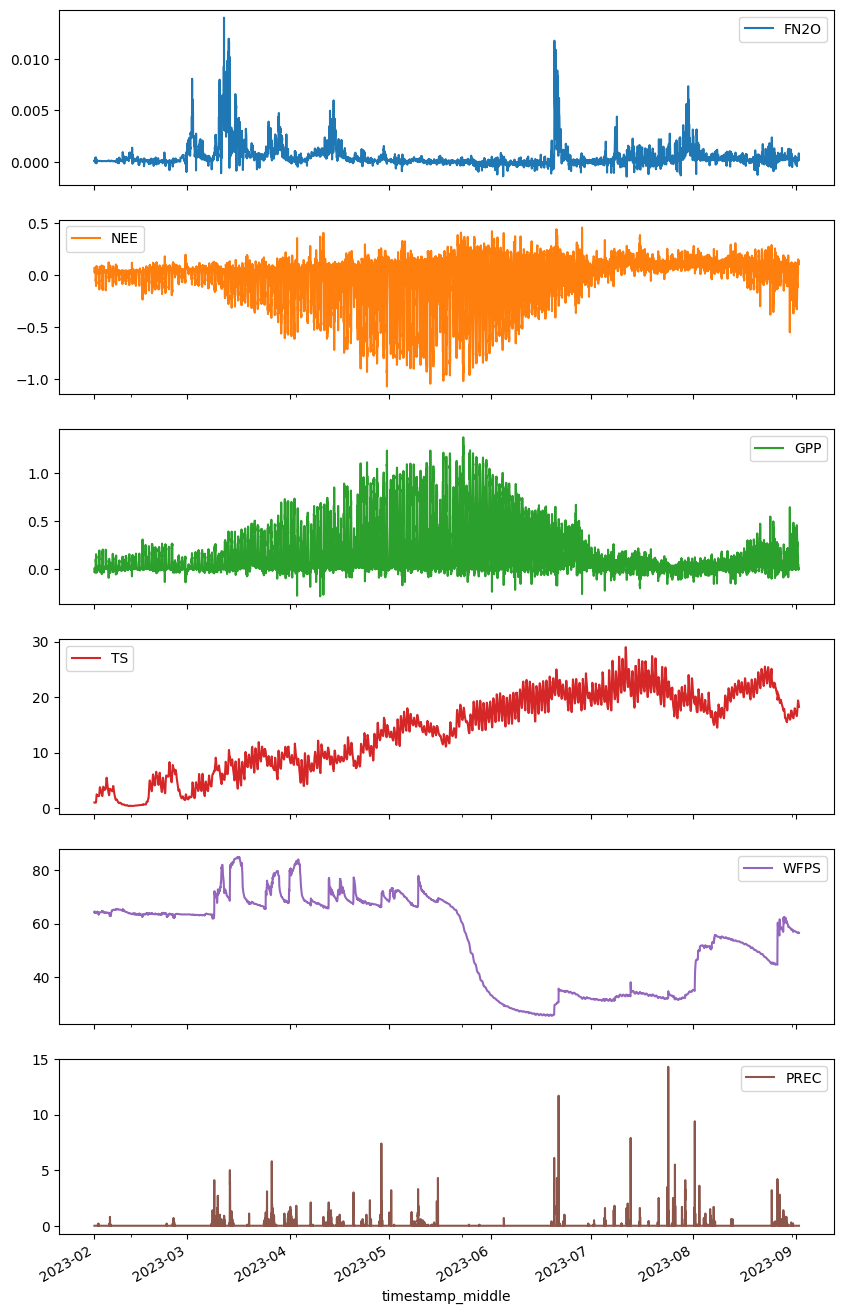

In [2]:
df = pd.read_csv('../data/processed/DRIVERS_dataset_0.5h.csv', low_memory=False)

# Define the columns we are interested and rename
rename_dict = {
    'flux_n2o_qcf_f_rf': 'FN2O',
    'flux_nee_qcf_f_mds': 'NEE',
    'flux_gpp': 'GPP',
    'ts_0.05': 'TS',
    'wfps_0.15': 'WFPS',
    'prec': 'PREC'
}
df.rename(columns=rename_dict, inplace=True)

# Convert units
df['FN2O'] = df['FN2O'] * 60 * 30 * 28.014 * 1e-9 * 1e-3 * 1e4 # nmol N2O m-2 s-1 → kg N2O-N ha-1 30min-1
df['NEE'] = df['NEE'] * 60 * 30 * 12.011 * 1e-6 # umol CO2 m-2 s-1 → g C m-2 30min-1
df['GPP'] = df['GPP'] * 60 * 30 * 12.011 * 1e-6 # umol CO2 m-2 s-1 → g C m-2 30min-1
  
# Timestamp to datetime and set as index
df['timestamp_middle'] = pd.to_datetime(df['timestamp_middle'])
df.set_index('timestamp_middle', inplace=True)

# Select period and columns
cols = ['FN2O', 'NEE', 'GPP', 'TS', 'WFPS', 'PREC']
df = df.loc['2022-09-01':'2023-10-05', cols].copy()

# Plot
indat = df.copy()
start = '2023-02-01'
end = '2023-09-01'
indat = indat[start:end]
indat.plot(figsize=(10,3*len(cols)), x_compat=True, subplots=True);

df

## PRS

In [3]:
prs = pd.read_csv("../data/raw/PRS_nutrients.csv") 
# Rename column names so all lower case, no spaces or special characters
prs.columns = prs.columns.str.lower().str.replace(' ', '_').str.replace(r'[^a-zA-Z0-9_]', '')
# Fix date to a datetime object using vectorized operations
prs["burial_dt"] = pd.to_datetime(prs["burial_date"], format='%m/%d/%Y', errors='coerce')
prs["retrieval_dt"] = pd.to_datetime(prs["retrieval_date"], format='%m/%d/%Y', errors='coerce')
prs["mean_dt"] = prs["burial_dt"] + (prs["retrieval_dt"] - prs["burial_dt"]) / 2
prs['NO3_PRS'] = prs['no3-n']
# Aggregate across chambers
prs_agg = prs.groupby(['burial_dt', 'retrieval_dt'])['NO3_PRS'].agg(
    NO3_PRS=('mean'),
    NO3_PRS_std=('std')
).reset_index()
# Show df
prs_agg

,burial_dt,retrieval_dt,NO3_PRS,NO3_PRS_std
0,2023-03-17,2023-04-04,256.0,199.506892
1,2023-04-04,2023-04-21,416.2,356.010112
2,2023-04-21,2023-05-10,194.0,296.466693
3,2023-05-10,2023-05-31,51.4,31.061230
4,2023-06-28,2023-07-11,132.6,85.862099
5,2023-08-02,2023-08-17,201.6,103.912463
6,2023-08-17,2023-09-05,254.6,125.382614


## Nmin

,NO3,NH4,N_MIN,N_MIN_std
date,,,,
2022-10-03,6.301392,2.418680,8.720071,NaN
2022-12-08,34.328424,0.258021,34.586446,5.089241
2023-03-08,53.287522,20.484209,73.771731,36.881289
2023-05-19,9.637637,2.096852,11.734489,1.783641
2023-08-04,30.758479,0.412991,27.066688,8.110241


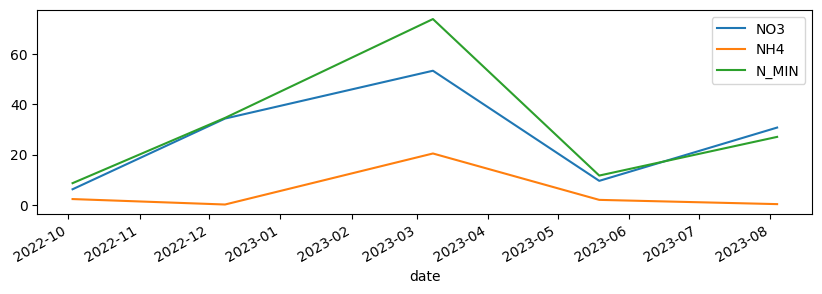

In [4]:
nmin = pd.read_csv('../data/raw/Nmin.csv')

# Fix column names so all lower case, no spaces or special characters
nmin.columns = nmin.columns.str.lower().str.replace(' ', '_').str.replace(r'[^a-zA-Z0-9_]', '')
rename_dict = {
    'no3_kgha_mean_0-30': 'NO3',
    'nh4_kgha_mean_0-30': 'NH4',
    'n_min_kgha_mean_0-30': 'N_MIN',
    'n_min_kgha_std_0-30': 'N_MIN_std'
}
nmin.rename(columns=rename_dict, inplace=True)

# Select column we are interested in
nmin = nmin[['NO3', 'NH4', 'N_MIN', 'N_MIN_std', 'date']].copy()
# Fix date to a datetime object
nmin['date'] = pd.to_datetime(nmin['date'], format='%Y-%m-%d')
# set timestamp as index
nmin.set_index('date', inplace=True)


nmin[['NO3', 'NH4', 'N_MIN']].plot(figsize=(10,3), x_compat=True);
nmin.head()

# ANALYSIS

## Nmin vs. FN2O-EDDY

In [5]:
# Compute the cumulative FN2O in a window of days at the time of the sampling
n_days = 7
n2o_agg = df[['FN2O', 'NEE', 'GPP', 'PREC']].resample('D').sum().rolling(window=n_days, center=True).sum().reset_index() # days before and after the sampling

# Rolling mean for WFPS
wfps_rolling = df[['TS']].resample('D').mean().rolling(window=n_days, center=True).mean().reset_index()
n2o_agg = pd.merge(n2o_agg, wfps_rolling, on='timestamp_middle')

df_nmin = pd.merge(nmin, n2o_agg, left_index=True, right_on='timestamp_middle')
df_nmin['sampling_index'] = range(len(df_nmin))
df_nmin

,NO3,NH4,N_MIN,N_MIN_std,timestamp_middle,FN2O,NEE,GPP,PREC,TS,sampling_index
32,6.301392,2.418680,8.720071,NaN,2022-10-03,0.050509,9.845401,29.304275,23.2,13.579783,0
98,34.328424,0.258021,34.586446,5.089241,2022-12-08,0.027125,8.839980,4.106199,11.2,4.044583,1
188,53.287522,20.484209,73.771731,36.881289,2023-03-08,0.418547,6.539039,15.810037,49.1,5.294574,2
260,9.637637,2.096852,11.734489,1.783641,2023-05-19,0.006556,-36.304790,110.726006,0.0,13.765144,3
337,30.758479,0.412991,27.066688,8.110241,2023-08-04,0.196000,37.042655,4.318122,44.2,18.084512,4


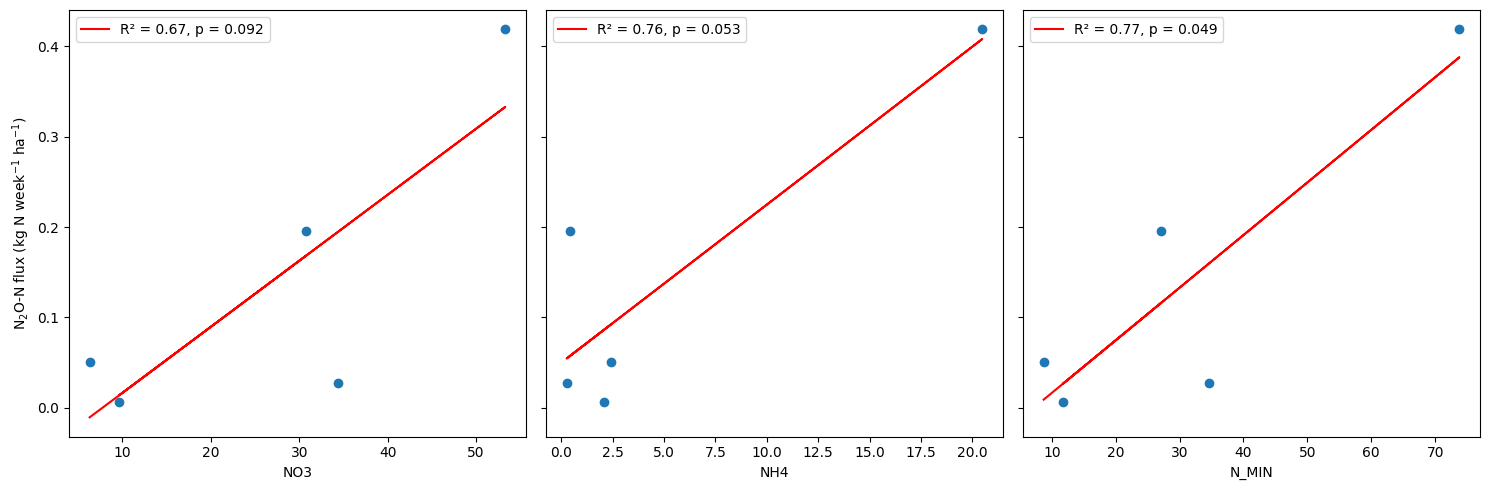

In [6]:
# Copy the dataset
indat = df_nmin.copy()

# Select the columns to plot
nmin_cols = ['NO3', 'NH4', 'N_MIN']

# Number of variables to plot
num_vars = len(nmin_cols)

# Create a shared y-axis figure
fig, axes = plt.subplots(nrows=1, ncols=num_vars, figsize=(5 * num_vars, 5), sharey=True)

# Loop through each column in `nmin`
for i, c in enumerate(nmin_cols):
    ax = axes[i]  # Select subplot
    
    # Extract the relevant data
    X = indat[c].values  # Independent variable (1D array)
    y = indat['FN2O'].values  # Dependent variable

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(X, y)
    y_pred = slope * X + intercept  # Predicted values

    # Calculate R² value
    r2 = r2_score(y, y_pred)

    # Scatter plot
    ax.scatter(X, y)
    ax.plot(X, y_pred, color='red', 
            label=f'R² = {r2:.2f}, p = {p_value:.3f}')  # Regression line

    # Labels
    ax.set_xlabel(c)
    if i == 0:
        ax.set_ylabel('N$_{2}$O-N flux (kg N week$^{-1}$ ha$^{-1}$)')

    ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

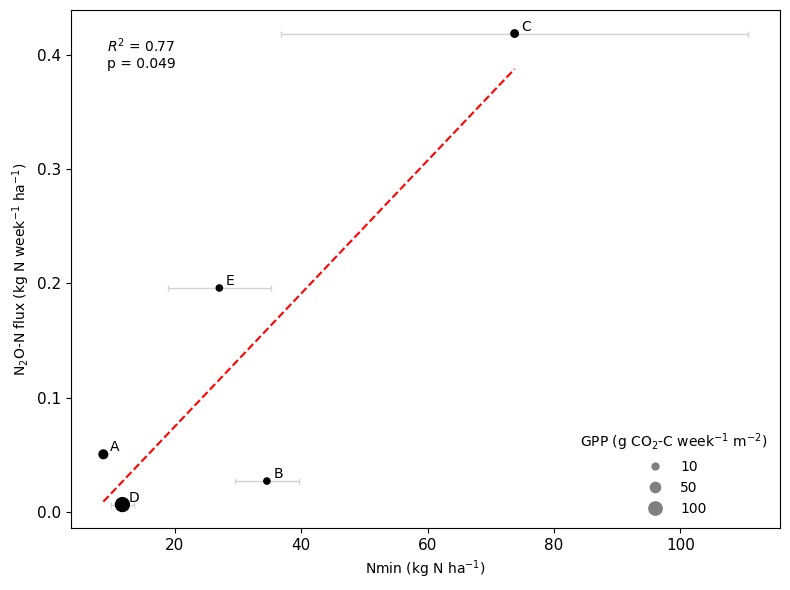

In [7]:
def plot_NMIN_vs_EC_FN2O(ax):
    
    indat = df_nmin.sort_values('N_MIN')
    # Extract the relevant data
    X = indat['N_MIN'].values  # Independent variable (1D array)
    y = indat['FN2O'].values  # Dependent variable
    std_X = indat['N_MIN_std'].values
    sizes = 20 + 80 * (indat['GPP'].values - indat['GPP'].min()) / (indat['GPP'].max() - indat['GPP'].min())

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(X, y)
    y_pred = slope * X + intercept  # Predicted values

    # Calculate R² value
    r2 = r2_score(y, y_pred)

    # Plot
    ax.scatter(X, y, s=sizes, color='black', zorder=2)
    ax.errorbar(X, y, xerr=std_X, fmt='none', ecolor='lightgray', elinewidth=1, capsize=2, zorder=1)

    # Annotate each point with its sampling index in the form of a letter
    for xi, yi, idx in zip(X, y, indat['sampling_index']):
        ax.text(xi+1, yi, string.ascii_uppercase[idx], ha='left', va='bottom')
        
    ax.plot(X, y_pred, color='red', linestyle='--')  # suppress legend entry
    
    # R² and p-value as annotation
    ax.annotate(f'$R^2$ = {r2:.2f}\np = {p_value:.3f}', xy=(0.05, 0.95),
                xycoords='axes fraction', ha='left', va='top')

    # Create custom size legend using the same normalization
    size_min, size_max = indat['GPP'].min(), indat['GPP'].max()
    legend_vals = [10, 50, 100]
    legend_sizes = 20 + 80 * (np.array(legend_vals) - size_min) / (size_max - size_min)
    legend_pts = [Line2D([0], [0], marker='o', color='gray', linestyle='None',
                        markersize=np.sqrt(s), label=f'{val}')  # use sqrt because s is area
                for s, val in zip(legend_sizes, legend_vals)]
    # Add legend
    ax.legend(handles=legend_pts, title='GPP (g CO$_2$-C week$^{-1}$ m$^{-2}$)', loc='lower right', frameon=False)

    # Labels
    ax.set_xlabel('Nmin (kg N ha$^{-1}$)')
    ax.set_ylabel('N$_{2}$O-N flux (kg N week$^{-1}$ ha$^{-1}$)')
    ax.tick_params(labelsize=11)

# Show the plot
fig, ax = plt.subplots(figsize=(8, 6))  # Create one axis
plot_NMIN_vs_EC_FN2O(ax)                          # Draw your plot on it
plt.tight_layout()
plt.show()

## N-PRS vs. FN2O-EDDY

In [8]:
# Function to aggregate over the burial time windows
def sum_fn2o_for_window(row, df, col, agg_type):
    start, end = row["burial_dt"], row["retrieval_dt"]
    return df.loc[start:end, col].agg(agg_type)

# Calculate aggregates
df_prs = prs_agg.copy()
df_prs["FN2O_cum"] = prs_agg.apply(lambda row: sum_fn2o_for_window(row, df, 'FN2O', 'sum'), axis=1)
df_prs["GPP_cum"] = prs_agg.apply(lambda row: sum_fn2o_for_window(row, df, 'GPP', 'sum'), axis=1)
df_prs["PREC_cum"] = prs_agg.apply(lambda row: sum_fn2o_for_window(row, df, 'PREC', 'sum'), axis=1)
df_prs["TS_mean"] = prs_agg.apply(lambda row: sum_fn2o_for_window(row, df, 'TS', 'mean'), axis=1)

# Select cols to keep
df_prs = df_prs[["burial_dt", "retrieval_dt", "NO3_PRS", "NO3_PRS_std", "FN2O_cum", "GPP_cum", "PREC_cum", "TS_mean"]].copy()
# Sort and add index
df_prs = df_prs.sort_values('burial_dt').reset_index(drop=True)
df_prs['sampling_index'] = range(1, len(df_prs)+1)

# Show result
df_prs


,burial_dt,retrieval_dt,NO3_PRS,NO3_PRS_std,FN2O_cum,GPP_cum,PREC_cum,TS_mean,sampling_index
0,2023-03-17,2023-04-04,256.0,199.506892,0.820671,119.483126,76.7,8.596099,1
1,2023-04-04,2023-04-21,416.2,356.010112,0.684997,150.125618,49.6,8.644254,2
2,2023-04-21,2023-05-10,194.0,296.466693,0.147700,263.829131,66.5,13.094946,3
3,2023-05-10,2023-05-31,51.4,31.061230,-0.008944,357.716937,14.2,14.913832,4
4,2023-06-28,2023-07-11,132.6,85.862099,0.110284,39.368372,19.8,21.126172,5
5,2023-08-02,2023-08-17,201.6,103.912463,0.294809,17.993263,22.8,19.010746,6
6,2023-08-17,2023-09-05,254.6,125.382614,0.222877,95.610863,50.4,20.225932,7


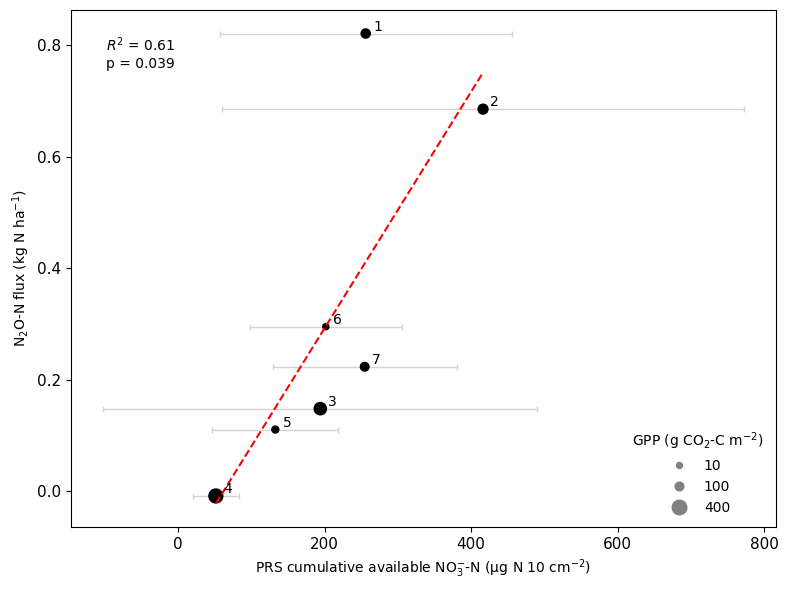

In [9]:
def plot_PRS_vs_EC_FN2O(ax):

    indat = df_prs.sort_values('NO3_PRS')
    # Extract values
    X = indat['NO3_PRS'].values
    y = indat['FN2O_cum'].values
    std_X = indat['NO3_PRS_std'].values
    sizes = 20 + 80 * (indat['GPP_cum'].values - indat['GPP_cum'].min()) / (indat['GPP_cum'].max() - indat['GPP_cum'].min())
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(X, y)
    r2 = r2_score(y, slope * X + intercept)
    y_pred = slope * X + intercept

    # Plot
    ax.scatter(X, y, s=sizes, color='black', zorder=2)
    ax.errorbar(X, y, xerr=std_X, fmt='none', ecolor='lightgray', elinewidth=1, capsize=2, zorder=1)
    ax.plot(X, y_pred, color='red', linestyle='--') 

    # Annotate each point with its sampling index
    for xi, yi, idx in zip(X, y, indat['sampling_index']):
        ax.text(xi+10, yi, str(idx), ha='left', va='bottom')

    # R² and p-value as annotation
    ax.annotate(f'$R^2$ = {r2:.2f}\np = {p_value:.3f}', xy=(0.05, 0.95),
                xycoords='axes fraction', ha='left', va='top')
    
    # Create custom size legend using the same normalization
    size_min, size_max = indat['GPP_cum'].min(), indat['GPP_cum'].max()
    legend_vals = [10, 100, 400]

    legend_sizes = 20 + 80 * (np.array(legend_vals) - size_min) / (size_max - size_min)
    legend_pts = [Line2D([0], [0], marker='o', color='gray', linestyle='None',
                        markersize=np.sqrt(s), label=f'{val}')  # use sqrt because s is area
                for s, val in zip(legend_sizes, legend_vals)]
    # Add legend
    ax.legend(handles=legend_pts, title='GPP (g CO$_2$-C m$^{-2}$)', loc='lower right', frameon=False)

    # Labels and styling
    ax.set_xlabel('PRS cumulative available NO$_{3}^{-}$-N (μg N 10 cm$^{-2}$)')
    ax.set_ylabel('N$_2$O-N flux (kg N ha$^{-1}$)')
    ax.tick_params(labelsize=11)

    return ax

# Call the plot function
fig, ax = plt.subplots(figsize=(8, 6))
plot_PRS_vs_EC_FN2O(ax)
plt.tight_layout()
plt.show()


Correlation matrix

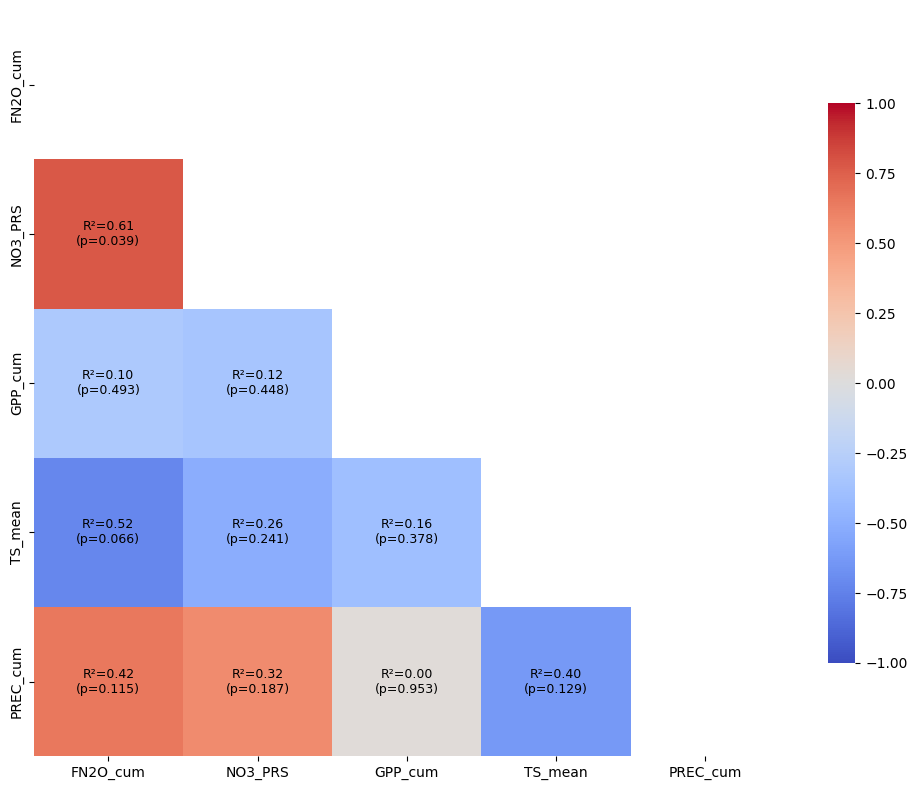

In [10]:
# Define your function first
def corr_matrix_with_pvalues(df):
    cols = df.columns
    n = len(cols)
    corr = np.zeros((n, n))
    pvals = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            x = df[cols[i]]
            y = df[cols[j]]
            mask = x.notna() & y.notna()
            if mask.sum() > 1:
                r, p = pearsonr(x[mask], y[mask])
            else:
                r, p = np.nan, np.nan
            corr[i, j] = r
            pvals[i, j] = p

    corr_df = pd.DataFrame(corr, columns=cols, index=cols)
    pval_df = pd.DataFrame(pvals, columns=cols, index=cols)
    return corr_df, pval_df

# Calculate correlation and p-values
corr_df, pval_df = corr_matrix_with_pvalues(df_prs[['FN2O_cum', 'NO3_PRS', 'GPP_cum', 'TS_mean', 'PREC_cum']])

# Plotting
mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .75})

# Add correlation values and p-values as text
for i in range(corr_df.shape[0]):
    for j in range(i):
        r_val = corr_df.iloc[i, j]
        p_val = pval_df.iloc[i, j]
        r2_val = r_val ** 2 if not np.isnan(r_val) else np.nan
        text = f'R²={r2_val:.2f}\n(p={p_val:.3f})' if not np.isnan(r2_val) else ''
        plt.text(j + 0.5, i + 0.5, text,
                 ha='center', va='center', fontsize=9, color='black')
plt.tight_layout()
plt.show()


# FINAL FIG

TOP PANEL 
  
   
To show when the soil N measurements were conducted



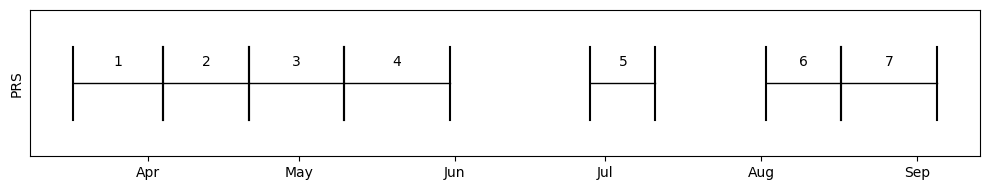

In [11]:
def plot_prs_segments(ax, prs):
    """Plot PRS segment bars on a given axis."""
    prs = prs.sort_values("burial_dt").reset_index(drop=True)
    prs["segment_id"] = range(1, len(prs) + 1)
    y = 1

    for _, row in prs.iterrows():
        ax.plot([row["burial_dt"], row["retrieval_dt"]], [y, y], color='black', lw=1)
        ax.plot([row["burial_dt"], row["burial_dt"]], [y - 0.05, y + 0.05], color='black')
        ax.plot([row["retrieval_dt"], row["retrieval_dt"]], [y - 0.05, y + 0.05], color='black')
        ax.text(row["mean_dt"], y + 0.02, str(row["segment_id"]), ha='center', va='bottom')

    ax.set_ylim(0.9, 1.1)
    ax.set_yticks([])
    ax.set_ylabel("PRS")
    return ax

fig, ax = plt.subplots(figsize=(10, 2))
plot_prs_segments(ax, prs[prs['chamber'] == 1])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

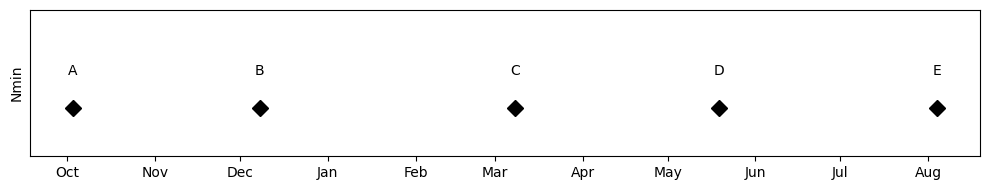

In [12]:
def plot_nmin_sampling(ax, nmin):
    """Plot diamonds for Nmin sampling dates on a given axis."""
    y = 1
    letters = string.ascii_uppercase  # 'A', 'B', 'C', ...

    for i, dt in enumerate(nmin.index):
        ax.plot(dt, y, marker='D', color='black', markersize=8)
        ax.text(dt, y + 0.03, letters[i], ha='center', va='bottom')
    
    ax.set_ylim(0.95, 1.1)
    ax.set_yticks([])
    ax.set_ylabel("Nmin")
    return ax

fig, ax = plt.subplots(figsize=(10, 2))
plot_nmin_sampling(ax, nmin)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

FINAL COMBINED FIGURE

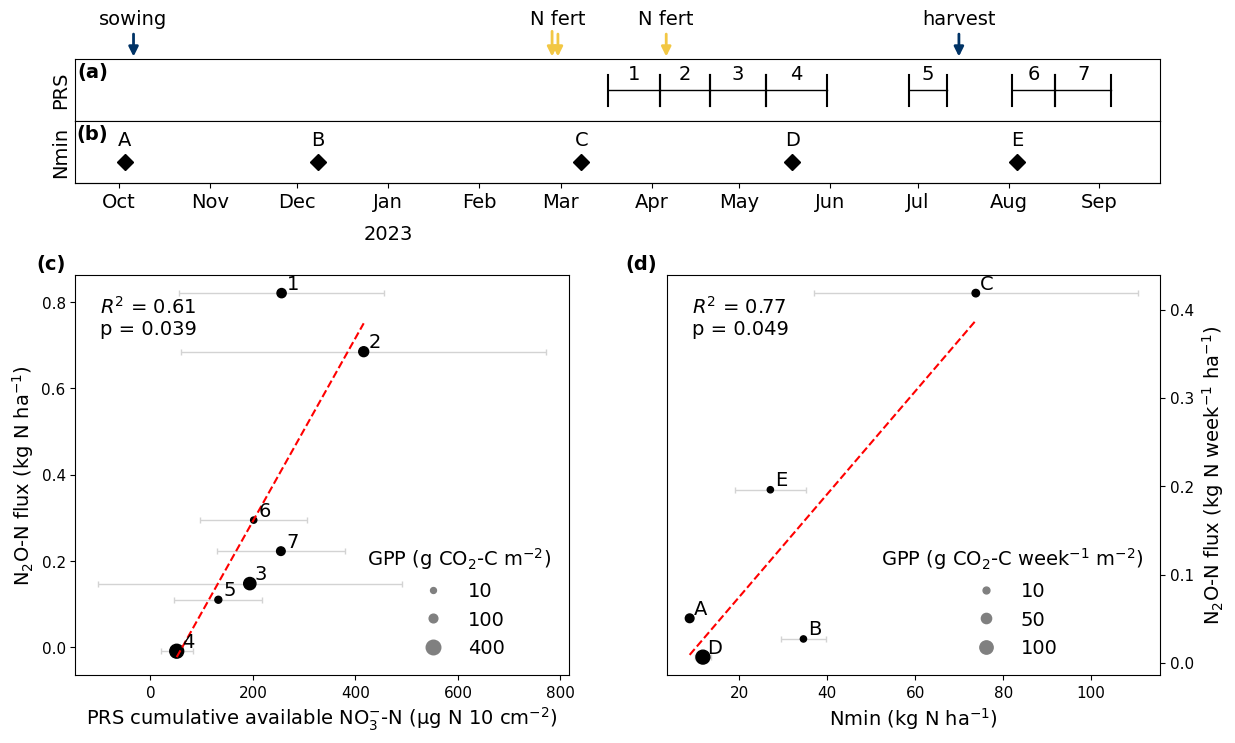

In [13]:
plt.rcParams.update({'font.size': 14})  # Set global font size
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(nrows=4, ncols=2, figure=fig,
              height_ratios=[1, 1, 1.5, 6.5],  # nearly zero for spacing row
              hspace=0)

# Top two rows: timeline plots (stacked)
ax_prs_timeline = fig.add_subplot(gs[0, :])
ax_nmin_timeline = fig.add_subplot(gs[1, :], sharex=ax_prs_timeline)

# Spacer row (invisible): row 2 — do nothing here

# Bottom row: result plots (side by side)
ax_PRS = fig.add_subplot(gs[3, 0])
ax_NMIN = fig.add_subplot(gs[3, 1])

# Plot timeline data
plot_prs_segments(ax_prs_timeline, prs[prs['chamber'] == 1])
plot_nmin_sampling(ax_nmin_timeline, nmin)

# Define labels and colors for the management events
event_lines = [
    {'date': '2022-10-06', 'color': '#003366', 'linestyle': ':', 'label': 'sowing'},
    {'date': '2023-07-15', 'color': '#003366', 'linestyle': '--', 'label': 'harvest'}, # wheat harvest
    {'date': '2023-02-26', 'color': '#F2C744', 'linestyle': '-', 'label': None},
    {'date': '2023-02-28', 'color': '#F2C744', 'linestyle': '-', 'label': 'N fert'},
    {'date': '2023-04-06', 'color': '#F2C744', 'linestyle': '-', 'label': 'N fert'},  # second mineral fert
]

# Add management
for event in event_lines:
    event_date = pd.to_datetime(event['date'])
    ax_prs_timeline.annotate(
        text=event['label'],
        xy=(mdates.date2num(event_date), 1),
        xytext=(mdates.date2num(event_date), 1.5),
        xycoords=('data', 'axes fraction'),
        textcoords=('data', 'axes fraction'),
        ha='center', va='bottom', color='black',
        arrowprops=dict(
            arrowstyle='-|>',
            color=event['color'],
#            linestyle=event['linestyle'],
            lw=2.0
        ),
        annotation_clip=False
    )

# Format bottom timeline axis
ax_prs_timeline.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_nmin_timeline.xaxis.set_major_locator(mdates.MonthLocator())
ax_nmin_timeline.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
secax = ax_nmin_timeline.secondary_xaxis('bottom')
secax.xaxis.set_major_locator(mdates.YearLocator())
secax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
secax.tick_params(axis='x', length=0, pad=30)

# Plot bottom panels
plot_PRS_vs_EC_FN2O(ax_PRS)
plot_NMIN_vs_EC_FN2O(ax_NMIN)

# Move y-axis of NMIN plot to the right
ax_NMIN.yaxis.tick_right()
ax_NMIN.yaxis.set_label_position("right")

# Labels
ax_prs_timeline.text(0.03, 0.94, '(a)', transform=ax_prs_timeline.transAxes, fontweight='bold', va='top', ha='right')
ax_nmin_timeline.text(0.03, 0.94, '(b)', transform=ax_nmin_timeline.transAxes, fontweight='bold', va='top', ha='right')
ax_PRS.text(-0.02, 1.05, '(c)', transform=ax_PRS.transAxes, fontweight='bold', va='top', ha='right')
ax_NMIN.text(-0.02, 1.05, '(d)', transform=ax_NMIN.transAxes, fontweight='bold', va='top', ha='right')

# Show or save
plt.savefig("../figures/soilN_vs_N2O.png", dpi=300, bbox_inches='tight')
plt.show()
